<a href="https://colab.research.google.com/github/Sontam3000/-META_DATA_FEATURE_EXTRACTION-_Stacked_Ensemble0_Multimodal_Pricing_-_Category_Prediction-1-/blob/main/%5BMETA_DATA_FEATURE_EXTRACTION%5D_Stacked_Ensemble0_Multimodal_Pricing_%26_Category_Prediction_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##[META DATA FEATURE EXTRACTION] STACKED ENSEMBLE MULTIMODAL PRICING & CATEGORY PREDICTION

####Data: Fashion-MNIST images + engineered metadata

####Tasks:

Classification – predict clothing category (10 classes)

Regression – predict a synthetic price you construct from metadata + class signals

Models (Level-0): Logistic Regression, Decision Tree (ID3-like), MLP (ANN)

Meta-learner (Level-1): Logistic Regression (for classification), Linear Regression (for price)


---


### Hybrid Stacked Model
A hybrid stacked model (or stacked ensemble) blends diverse algorithms—each good at capturing different patterns—by training a meta-model on their predictions.


Level-0 (Base Models)

Logistic Regression: learns linear trends
Decision Tree: learns rules and interactions
ANN (MLP):  learns complex nonlinear patterns	Each model predicts class probabilities independently

Level-1 (Meta-Learner)

Logistic Regression (for classification) or Linear Regression (for price)	Learns how to weight and combine the base models’ predictions for the final output


---


### DATASET STRUCTURE

Dataset type: Image classification

Goal: Predict the type of clothing shown in a grayscale image

Total samples: 70,000 images

Training set: 60,000 images

Test set: 10,000 images

Image size: 28 × 28 pixels

Color: Grayscale (each pixel ∈ [0, 255])

Format: Each image is a 2-D NumPy array (28×28), and each label is an integer (0–9).


---
### DATA SPLIT  

| Split    | Variable name  | Shape       | Description      |
| ---------| ------------- | ------------ | ---------------- |
| Training images | `x_train` or `train_images` | `(60000, 28, 28)` | 60 000 grayscale images |
| Training labels | `y_train` or `train_labels` | `(60000,)`        | Integer labels 0–9      |
| Test images     | `x_test` or `test_images`   | `(10000, 28, 28)` | 10 000 grayscale images |
| Test labels     | `y_test` or `test_labels`   | `(10000,)`        | Integer labels 0–9      |

### DATA LABELS

| Label ID | Class Name  |
| -------- | ----------- |
| 0        | T-shirt/top |
| 1        | Trouser     |
| 2        | Pullover    |
| 3        | Dress       |
| 4        | Coat        |
| 5        | Sandal      |
| 6        | Shirt       |
| 7        | Sneaker     |
| 8        | Bag         |
| 9        | Ankle boot  |



### DATA LOADING

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


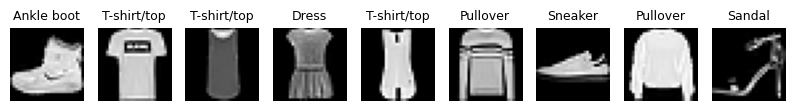

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
np.random.seed(SEED) #repeatable splits

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

fig, axes = plt.subplots(1, len(class_names) - 1, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(class_names[train_labels[i]], fontsize=9)
    ax.axis('off')

plt.show()

In [ ]:
from collections import Counter
cnt = Counter(train_labels)
for i in cnt:
    print(f'{class_names[i]}: {cnt[i]}')

Ankle boot: 6000
T-shirt/top: 6000
Dress: 6000
Pullover: 6000
Sneaker: 6000
Sandal: 6000
Trouser: 6000
Shirt: 6000
Coat: 6000
Bag: 6000


### DATA PREPROCESSING


In [ ]:
## NORMALIZING IMAGE TO [0-1]
train_images = train_images / 255.0
test_images = test_images / 255.0
print(train_images.min())
print(test_images.max())

0.0
1.0


In [ ]:
# MAKE VALIDATION SPLIT
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    train_images,
    train_labels,
    test_size=0.2, # 20% of train data i.e 12000
    random_state=SEED
    )
X_test = test_images
Y_test = test_labels

### META DATA CREATION
Right now, each image is a 28×28 pixel matrix(784 pixels per image)

Hard for logistic regression or decision trees(simple model) to interpret.

Extract summary features from image that describe each image in a compact, interpretable way like its brightness, edge density, texture, and shape.

In [ ]:
from dataclasses import astuple
import numpy as np
import pandas as pd
from tqdm import tqdm #progress bar
from skimage.filters import sobel, laplace, threshold_otsu #extract edges, textures, and shape cues
from skimage.feature import graycomatrix, graycoprops
from skimage import exposure
from scipy.stats import skew #measure brightness asymmetry

def feature_extraction(img):
  feature_image = img.astype(np.float32) #ensure float

  mean_intensity = np.mean(feature_image) #average brightness (dark=0, bright=1)
  std_intensity = np.std(feature_image) #variability in brightness(contrast)
  min_intensity = np.min(feature_image) #darkest pixel value
  max_intensity = np.max(feature_image) #brightest pixel value
  skewness = skew(feature_image.flatten()) #measure brightness asymmetry (pixels skewed to dark or bright)

  edges = sobel(feature_image) #extract edges(in edge brightness changes sharply)
  edge_density = (edges > np.percentile(edges, 95)).mean() #top 5% pixel with sharp edge response

  coords = np.argwhere(feature_image > 0) #coordinates of non-zero
  (y0, x0), (y1, x1) = coords.min(axis=0), coords.max(axis=0) #min and max coordinates
  height, width = y1 - y0 + 1, x1 - x0 + 1 #height and width of bounding box
  aspect_ratio = width / max(height, 1) #ratio of height to width wide clothe>1, tall clothe<1

  bins = exposure.rescale_intensity(feature_image, out_range=(0, 15)).astype(np.uint8) #rescales pixel values from 0-1 into the range 0-15, graycomatrix() require integer pixel values for computing texture patterns
  glcm = graycomatrix(bins, distances=[1], angles=[0], levels=16, symmetric=True, normed=True)
  contrast = graycoprops(glcm, 'contrast')[0, 0]#local variation
  entropy = -(glcm* np.log(glcm +1e-12)).sum() #randomness in texture, more is irregular or say detailed texture

  return [mean_intensity, std_intensity, min_intensity, max_intensity, skewness, edge_density, aspect_ratio, contrast, entropy]


In [ ]:
train_features = [feature_extraction(img) for img in tqdm(x_train, desc="Extracting the train features")]
val_features = [feature_extraction(img) for img in tqdm(x_val, desc="Extracting the validation features")]

cols = ["mean_intensity", "std_intensity", "min_intensity", "max_intensity", "skewness", "edge_density", "aspect_ratio", "contrast", "entropy"]

df_train = pd.DataFrame(train_features, columns=cols)
df_val = pd.DataFrame(val_features, columns=cols)

df_train['label'] = y_train
df_val['label'] = y_val

test_features = [feature_extraction(img) for img in tqdm(X_test, desc="Extracting test features")]
cols = ["mean_intensity", "std_intensity", "min_intensity", "max_intensity", "skewness", "edge_density", "aspect_ratio", "contrast", "entropy"]

df_test = pd.DataFrame(test_features, columns=cols)
df_test["label"] = Y_test

print(df_train.shape)
print(df_train.head())
print(df_val.shape)
print(df_val.head())
print(df_test.shape)
print(df_test.head())

Extracting test features: 100%|██████████| 10000/10000 [00:13<00:00, 734.74it/s]

(48000, 10)
   mean_intensity  std_intensity  min_intensity  max_intensity  skewness  \
0        0.184659       0.342436            0.0            1.0  1.470922   
1        0.069578       0.164950            0.0            1.0  2.785917   
2        0.129982       0.218644            0.0            1.0  1.474074   
3        0.252956       0.322909            0.0            1.0  0.737536   
4        0.258448       0.230045            0.0            1.0  0.829505   

   edge_density  aspect_ratio   contrast   entropy  label  
0       0.05102      2.545455   3.007937  1.742766      7  
1       0.05102      0.464286   6.537037  1.770523      3  
2       0.05102      1.400000   3.588624  2.312112      5  
3       0.05102      0.750000  10.208995  3.092987      8  
4       0.05102      0.785714   9.171958  3.639985      6  
(12000, 10)
   mean_intensity  std_intensity  min_intensity  max_intensity  skewness  \
0        0.331248       0.318700            0.0            1.0  0.108269   
1      

In [ ]:
df_train.to_csv('train_features.csv', index=False)
df_val.to_csv('val_features.csv', index=False)
df_test.to_csv('test_features.csv', index=False)

In [ ]:
X_feature_train = df_train.drop('label', axis=1)
y_feature_train = df_train['label']

X_feature_val = df_val.drop('label', axis=1)
y_feature_val = df_val['label']

X_feature_test = df_test.drop('label', axis=1)
y_feature_test = df_test['label']

X_feature_train.shape, y_feature_train.shape, X_feature_val.shape, y_feature_val.shape, X_feature_test.shape, y_feature_test.shape

((48000, 9), (48000,), (12000, 9), (12000,), (10000, 9), (10000,))

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

scaler = StandardScaler()
X_feature_train_scaler = scaler.fit_transform(X_feature_train)
X_feature_val_scaler = scaler.transform(X_feature_val)
X_feature_test_scaler = scaler.transform(X_feature_test)

print("TRAIN \n",X_feature_train_scaler[:5])
print("VAL \n", X_feature_val_scaler[:5])
print("TEST \n", X_feature_test_scaler[:5])



TRAIN 
 [[-0.80392542  0.28273636  0.          0.3034806   0.91667327  0.06589382
   2.258142   -1.21335667 -1.5001953 ]
 [-1.71719367 -1.97838905  0.          0.3034806   2.50372648  0.06589382
  -0.9127119  -0.42405181 -1.45499707]
 [-1.23783402 -1.29434284  0.          0.3034806   0.9204774   0.06589382
   0.51293567 -1.0834823  -0.57309296]
 [-0.26192679  0.03397027  0.          0.3034806   0.03155808  0.06589382
  -0.47739966  0.39720392  0.6984566 ]
 [-0.21834132 -1.14909323  0.          0.3034806   0.14255513  0.06589382
  -0.42298563  0.16526426  1.58916922]]
VAL 
 [[ 0.35938328 -0.01964478  0.          0.3034806  -0.72789749  0.06589382
   0.08632968  0.24277471  0.53930035]
 [ 1.32798646  0.80829199  0.          0.3034806  -1.1023935   0.06589382
   0.62520041 -0.44002725  0.01529596]
 [-0.98263322 -0.35793065  0.          0.3034806   0.9736512   0.06589382
   1.66149026 -1.2056648  -1.11499184]
 [ 0.60847048  0.74128201  0.          0.3034806  -0.63027777  0.06589382
  -0.58

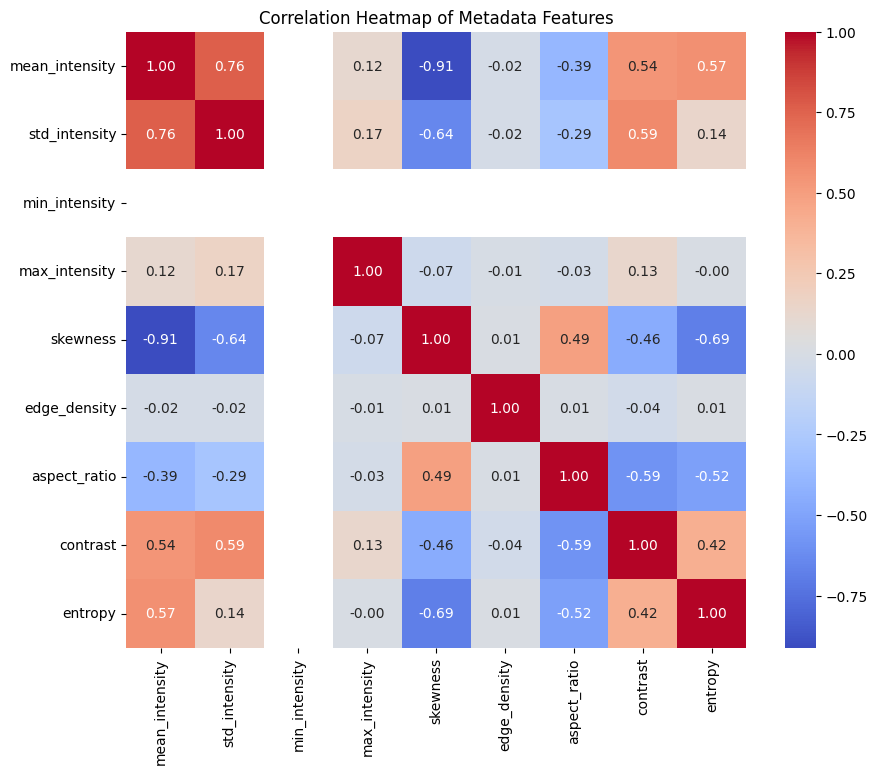

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_train.drop('label', axis=1).corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Metadata Features')
plt.show()


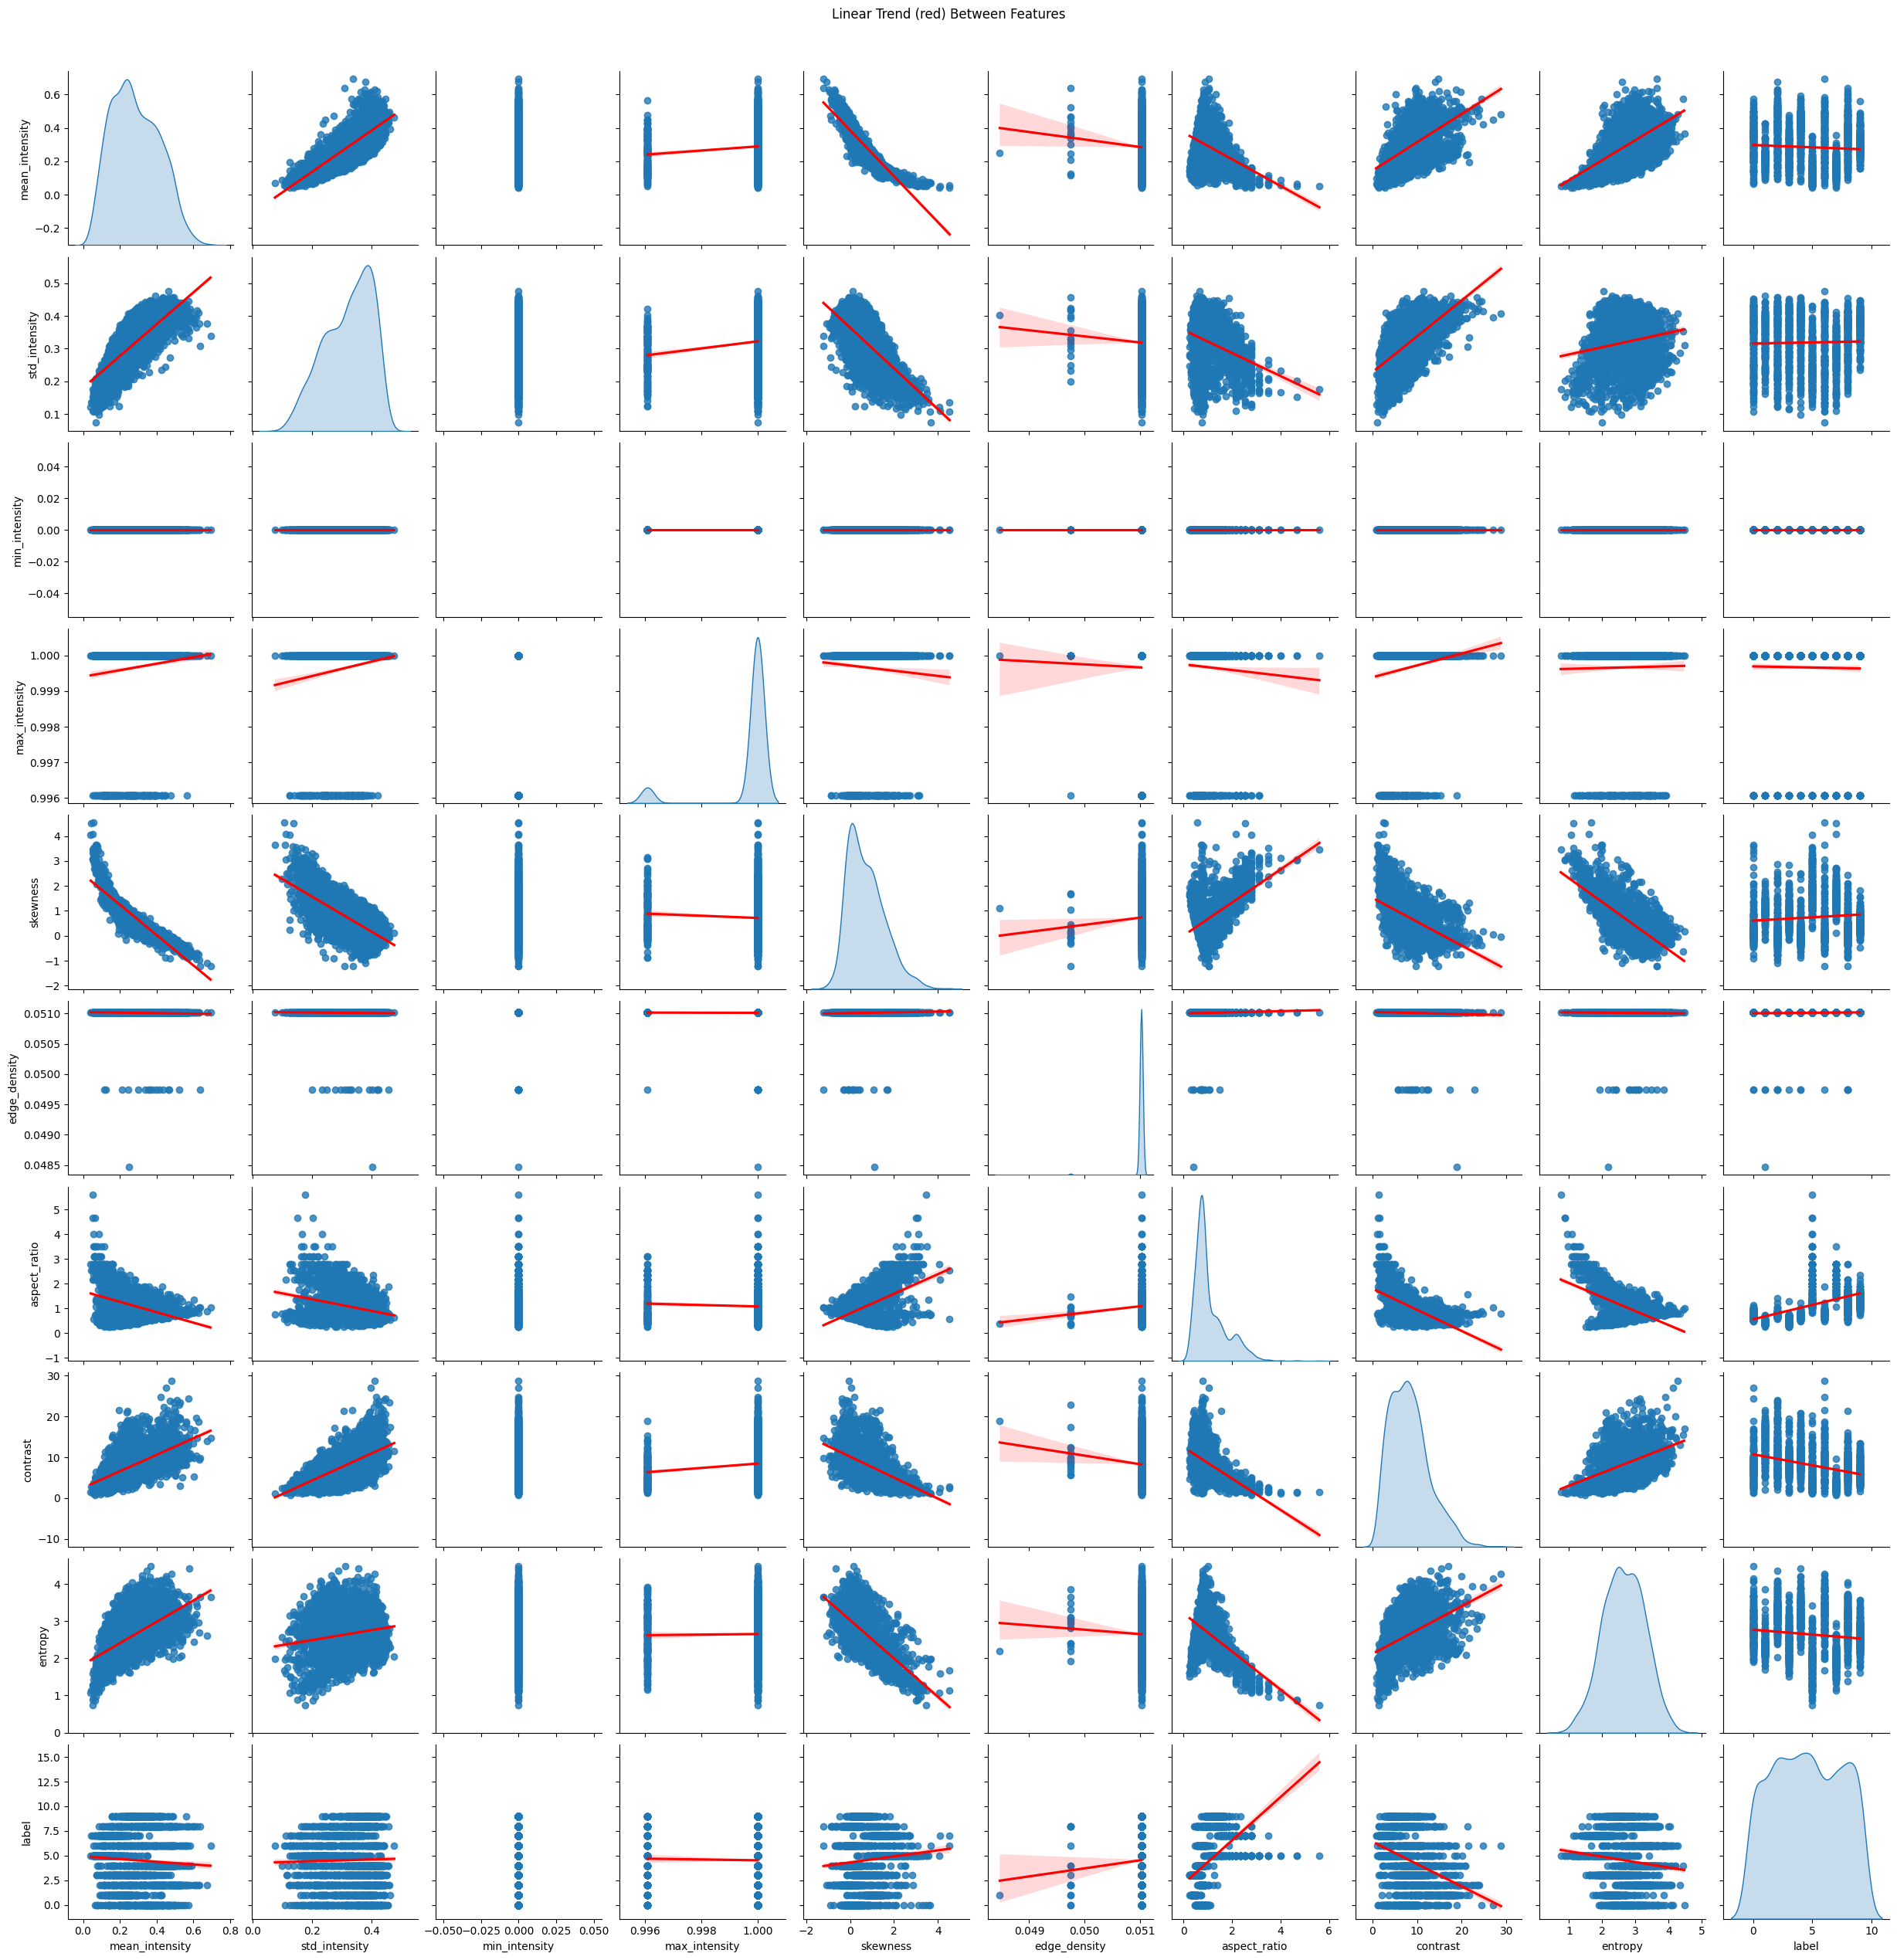

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_train.sample(2000, random_state=42),
             diag_kind='kde',
             kind='reg',  # regression line
             plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('Linear Trend (red) Between Features', y=1.02)
plt.show()


### DATA MODELING

### LOGISTIC RREGRESSION (SELF IMPLEMENTATION)


In [ ]:
def softmax(z):
  exp = np.exp(z - np.max(z, axis=0, keepdims=True))
  return exp / np.sum(exp, axis=0, keepdims=True)


In [ ]:
class MyLogisticRegression:
  def __init__(self, num_features, num_classes, learning_rate=0.1):
        self.W = np.zeros((num_classes, num_features))
        self.w_0 = np.zeros((num_classes, 1))
        self.learning_rate = learning_rate

  def fit(self, X, Y, epochs=1000, print_loss= True):
    Y = np.array(Y).astype(int)
    m= X.shape[1]
    losses = []
    for i in range(epochs):
      Z = np.dot(self.W, X) + self.w_0  # Z = W^T * X + w_0
      A = softmax(Z)
      Y_onehot = np.eye(self.W.shape[0])[Y.reshape(-1)].T  # (num_classes, m)
      loss =  -np.sum(Y_onehot * np.log(A + 1e-15)) / m  # Cross-entropy loss
      #loss= - (1 / m) * (np.mean(Y * np.log(A + 1e-15)) + np.mean((1 - Y) * np.log(1 - A + 1e-15)))

      # Compute loss (categorical cross-entropy)
      loss = -np.sum(Y_onehot * np.log(A + 1e-15)) / m
      # Gradients
      dW = (1/m) * np.dot((A - Y_onehot), X.T)
      db = (1/m) * np.sum(A - Y_onehot, axis=1, keepdims=True)

      # Update
      self.W = self.W - self.learning_rate * dW
      self.w_0 = self.w_0 - self.learning_rate * db

      if i % 100 == 0:
          losses.append(loss)
          if print_loss:
              print(f"Epoch {i}: Loss = {loss:.4f}")

    return losses

  def predict(self, X):
    Z_prediction = np.dot(self.W, X) + self.w_0
    A = softmax(Z_prediction)
    return np.argmax(A, axis=0)

In [ ]:
def Run_Experiment(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                   epochs=2000, learning_rate=0.1, print_loss=False):

    # Transpose
    X_train_T = X_train.T
    X_val_T   = X_val.T
    X_test_T  = X_test.T

    num_features = X_train_T.shape[0]
    num_classes  = len(np.unique(Y_train))

    model = MyLogisticRegression(num_features, num_classes, learning_rate)

    losses = model.fit(X_train_T, Y_train, epochs=epochs, print_loss=print_loss)

    Y_pred_val = model.predict(X_val_T)
    val_acc = np.mean(Y_pred_val == Y_val) * 100
    print(f"\nValidation Accuracy: {val_acc:.2f}%")


    Y_pred_test = model.predict(X_test_T)
    test_acc = np.mean(Y_pred_test == Y_test) * 100
    print(f"Final Test Accuracy (after tuning): {test_acc:.2f}%")

    d = {
        "losses": losses,
        "Y_pred_val": Y_pred_val,
        "Y_pred_test": Y_pred_test,
        "W": model.W.tolist(),
        "b": model.w_0.tolist(),
        "learning_rate": learning_rate,
        "epochs": epochs,
        "val_acc": val_acc,
        "test_acc": test_acc
    }

    return d


Epoch 0: Loss = 2.3026
Epoch 100: Loss = 1.6774
Epoch 200: Loss = 1.5359
Epoch 300: Loss = 1.4633
Epoch 400: Loss = 1.4170
Epoch 500: Loss = 1.3838
Epoch 600: Loss = 1.3584
Epoch 700: Loss = 1.3381
Epoch 800: Loss = 1.3212
Epoch 900: Loss = 1.3069
Epoch 1000: Loss = 1.2946
Epoch 1100: Loss = 1.2838
Epoch 1200: Loss = 1.2742
Epoch 1300: Loss = 1.2656
Epoch 1400: Loss = 1.2579
Epoch 1500: Loss = 1.2509
Epoch 1600: Loss = 1.2444
Epoch 1700: Loss = 1.2385
Epoch 1800: Loss = 1.2331
Epoch 1900: Loss = 1.2280
Epoch 2000: Loss = 1.2233
Epoch 2100: Loss = 1.2189
Epoch 2200: Loss = 1.2148
Epoch 2300: Loss = 1.2109
Epoch 2400: Loss = 1.2073
Epoch 2500: Loss = 1.2038
Epoch 2600: Loss = 1.2006
Epoch 2700: Loss = 1.1975
Epoch 2800: Loss = 1.1945
Epoch 2900: Loss = 1.1917

Validation Accuracy: 58.66%
Final Test Accuracy (after tuning): 58.52%


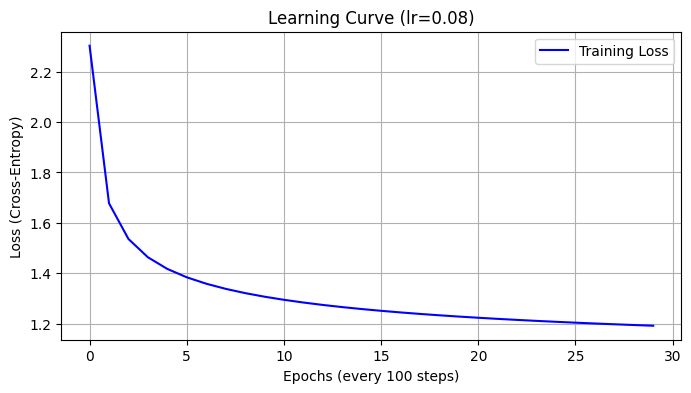

Validation Accuracy: 58.66%
Final Test Accuracy: 58.52%


In [ ]:
d = Run_Experiment(X_feature_train_scaler, y_feature_train, X_feature_val_scaler,
                   y_feature_val, X_feature_test_scaler, y_feature_test,
                   epochs = 3000, learning_rate = 0.08, print_loss = True)
# Plot learning curve (with costs)
losses = np.squeeze(d["losses"])
plt.figure(figsize=(8,4))
plt.plot(losses, color='blue', label='Training Loss')
plt.ylabel("Loss (Cross-Entropy)")
plt.xlabel("Epochs (every 100 steps)")
plt.title(f"Learning Curve (lr={d['learning_rate']})")
plt.legend()
plt.grid(True)
plt.show()

# Print accuracies
print(f"Validation Accuracy: {d['val_acc']:.2f}%")
print(f"Final Test Accuracy: {d['test_acc']:.2f}%")

### POLYNOMIAL FEATURE TRANSFORM


In [ ]:
poly = PolynomialFeatures(degree=4, include_bias=False)
X_feature_train_poly = poly.fit_transform(X_feature_train_scaler)
X_feature_val_poly = poly.transform(X_feature_val_scaler)
X_feature_test_poly = poly.transform(X_feature_test_scaler)

scaler1 = StandardScaler()
X_feature_train_poly_scaler = scaler1.fit_transform(X_feature_train_poly)
X_feature_val_poly_scaler = scaler1.transform(X_feature_val_poly)
X_feature_test_poly_scaler = scaler1.transform(X_feature_test_poly)

In [ ]:
class MyPolynomialLogisticRegression:
  def __init__(self, num_features, num_classes, learning_rate=0.1, lmd= 1):
        self.W = np.zeros((num_classes, num_features))
        self.w_0 = np.zeros((num_classes, 1))
        self.learning_rate = learning_rate
        self.lmd = lmd

  def fit(self, X, Y, epochs=1000, print_loss= True):
    Y = np.array(Y).astype(int)
    m= X.shape[1]
    losses = []
    for i in range(epochs):
      Z = np.dot(self.W, X) + self.w_0  # Z = W^T * X + w_0
      A = softmax(Z)
      Y_onehot = np.eye(self.W.shape[0])[Y.reshape(-1)].T  # (num_classes, m)

      # Compute loss (categorical cross-entropy)
      loss =  -np.sum(Y_onehot * np.log(A + 1e-15)) / m +(self.lmd / (2 * m)) * np.sum(self.W * self.W)
       # Cross-entropy loss
      #loss= - (1 / m) * (np.mean(Y * np.log(A + 1e-15)) + np.mean((1 - Y) * np.log(1 - A + 1e-15)))


      # Gradients
      dW = (1/m) * np.dot((A - Y_onehot), X.T)+ (self.lmd/m) * self.W
      db = (1/m) * np.sum(A - Y_onehot, axis=1, keepdims=True)

      # Update
      self.W = self.W - self.learning_rate * dW
      self.w_0 = self.w_0 - self.learning_rate * db

      if i % 100 == 0:
          losses.append(loss)
          if print_loss:
              print(f"Epoch {i}: Loss = {loss:.4f}")

    return losses

  def predict(self, X):
    Z_prediction = np.dot(self.W, X) + self.w_0
    A = softmax(Z_prediction)
    return np.argmax(A, axis=0)

def Run_Polynomial_Experiment(X_train, Y_train, X_val, Y_val, X_test, Y_test,
              epochs=2000, learning_rate=0.1, print_loss=False):

  # Transpose
  X_train_T = X_train.T
  X_val_T   = X_val.T
  X_test_T  = X_test.T

  num_features = X_train_T.shape[0]
  num_classes  = len(np.unique(Y_train))

  model = MyPolynomialLogisticRegression(num_features, num_classes, learning_rate)

  losses = model.fit(X_train_T, Y_train, epochs=epochs, print_loss=print_loss)

  Y_pred_val = model.predict(X_val_T)
  val_acc = np.mean(Y_pred_val == Y_val) * 100
  print(f"\nValidation Accuracy: {val_acc:.2f}%")


  Y_pred_test = model.predict(X_test_T)
  test_acc = np.mean(Y_pred_test == Y_test) * 100
  print(f"Final Test Accuracy (after tuning): {test_acc:.2f}%")

  d = {
    "losses": losses,
    "Y_pred_val": Y_pred_val,
    "Y_pred_test": Y_pred_test,
    "W": model.W.tolist(),
    "b": model.w_0.tolist(),
    "learning_rate": learning_rate,
    "epochs": epochs,
    "val_acc": val_acc,
    "test_acc": test_acc
  }

  return d


Epoch 0: Loss = 2.3026
Epoch 100: Loss = 1.2374
Epoch 200: Loss = 1.1545
Epoch 300: Loss = 1.1122
Epoch 400: Loss = 1.0852
Epoch 500: Loss = 1.0664
Epoch 600: Loss = 1.0519
Epoch 700: Loss = 1.0401
Epoch 800: Loss = 1.0302
Epoch 900: Loss = 1.0219
Epoch 1000: Loss = 1.0120
Epoch 1100: Loss = 0.9894
Epoch 1200: Loss = 1.0336
Epoch 1300: Loss = 0.9806
Epoch 1400: Loss = 0.9742
Epoch 1500: Loss = 1.0089
Epoch 1600: Loss = 1.0236
Epoch 1700: Loss = 0.9924
Epoch 1800: Loss = 0.9751
Epoch 1900: Loss = 0.9676
Epoch 2000: Loss = 0.9672
Epoch 2100: Loss = 0.9803
Epoch 2200: Loss = 1.0251
Epoch 2300: Loss = 1.0110
Epoch 2400: Loss = 0.9432
Epoch 2500: Loss = 0.9271
Epoch 2600: Loss = 0.9327
Epoch 2700: Loss = 0.9617
Epoch 2800: Loss = 0.9909
Epoch 2900: Loss = 0.9316

Validation Accuracy: 67.00%
Final Test Accuracy (after tuning): 66.53%


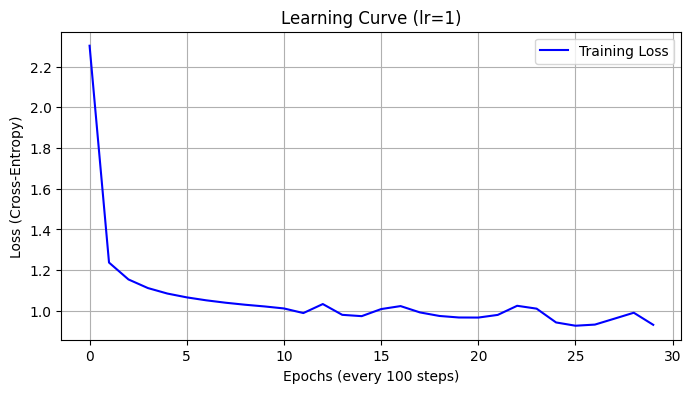

Validation Accuracy: 67.00%
Final Test Accuracy: 66.53%


In [ ]:
d = Run_Experiment(X_feature_train_poly_scaler, y_feature_train,
                   X_feature_val_poly_scaler,
                   y_feature_val, X_feature_test_poly_scaler, y_feature_test,
                   epochs = 3000, learning_rate = 1, print_loss = True)
# Plot learning curve (with costs)
losses = np.squeeze(d["losses"])
plt.figure(figsize=(8,4))
plt.plot(losses, color='blue', label='Training Loss')
plt.ylabel("Loss (Cross-Entropy)")
plt.xlabel("Epochs (every 100 steps)")
plt.title(f"Learning Curve (lr={d['learning_rate']})")
plt.legend()
plt.grid(True)
plt.show()

# Print accuracies
print(f"Validation Accuracy: {d['val_acc']:.2f}%")
print(f"Final Test Accuracy: {d['test_acc']:.2f}%")

penalty='l2',               
C=1.5,                       
solver='lbfgs',            
max_iter=3000,             
random_state=42

gave Validation Accuracy: 70.88%

Test Accuracy: 70.60%


Train accuracy ≈ Val accuracy, both low	Model can’t fit data (too simple)	Decrease λ (weaker regularization)

Train accuracy ≫ Val accuracy	Model fits training but not generalizing	Increase λ (stronger regularization)

So decreasing

### LOGISTIC REGRESSION (FROM SCIKIT-LEARN)

Validation Accuracy: 70.73%
Test Accuracy: 70.57%

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.64      0.68      0.66      1000
     Trouser       0.92      0.89      0.91      1000
    Pullover       0.57      0.61      0.59      1000
       Dress       0.67      0.73      0.70      1000
        Coat       0.54      0.61      0.57      1000
      Sandal       0.89      0.83      0.86      1000
       Shirt       0.40      0.28      0.33      1000
     Sneaker       0.82      0.83      0.82      1000
         Bag       0.77      0.73      0.75      1000
  Ankle boot       0.79      0.86      0.83      1000

    accuracy                           0.71     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.70      0.71      0.70     10000


Confusion Matrix:
 [[683   5  37  93  51   2  63   1  61   4]
 [  6 893  13  67  13   0   5   0   3   0]
 [ 37   1 611  19 153   0 156   0  23   0]
 [ 35  67  28 731

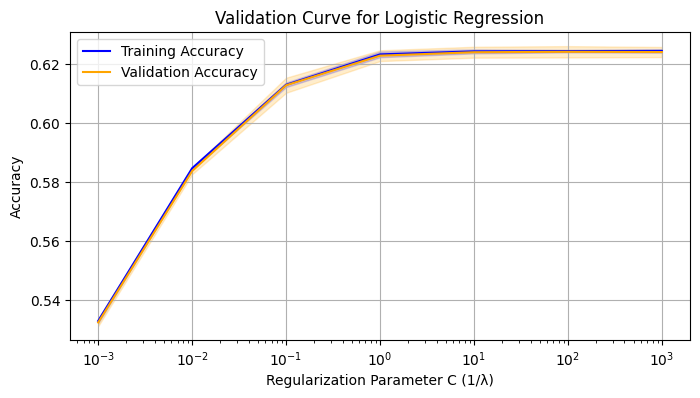

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import validation_curve

log_reg = LogisticRegression(
    #multi_class='multinomial',   deprecated new automatically does multinomial for multiclass # softmax (for >2 classes)
    penalty='l2',                # regularization type
    C=1,                       # inverse of regularization strength
    solver='lbfgs',    #large data          # handles multiclass well
    max_iter=3000,               # more iterations for convergence
    random_state=42
)

# training data
log_reg.fit(X_feature_train_poly_scaler, y_feature_train)

# validation and test sets
y_pred_val = log_reg.predict(X_feature_val_poly_scaler)
y_pred_test = log_reg.predict(X_feature_test_poly_scaler)

# Evaluate accuracy
val_acc = accuracy_score(y_feature_val, y_pred_val) * 100
test_acc = accuracy_score(y_feature_test, y_pred_test) * 100

print(f"Validation Accuracy: {val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

# Detailed report
print("\nClassification Report:\n", classification_report(y_feature_test, y_pred_test, target_names=class_names))

# Confusion matrix (optional)
cm = confusion_matrix(y_feature_test, y_pred_test)
print("\nConfusion Matrix:\n", cm)


param_range = np.logspace(-3, 3, 7)
train_scores, val_scores = validation_curve(
    log_reg,
    X_feature_train_scaler, y_feature_train,
    param_name="C",
    param_range=param_range,
    scoring="accuracy",
    cv=3
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8,4))
plt.semilogx(param_range, train_mean, label="Training Accuracy", color='blue')
plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, alpha=0.2, color='blue')

plt.semilogx(param_range, val_mean, label="Validation Accuracy", color='orange')
plt.fill_between(param_range, val_mean-val_std, val_mean+val_std, alpha=0.2, color='orange')

plt.title("Validation Curve for Logistic Regression")
plt.xlabel("Regularization Parameter C (1/λ)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### SLEF IMPLEMENTATION VS SCIKIT-LEARN

Prediction Probabilities From Self Implementation



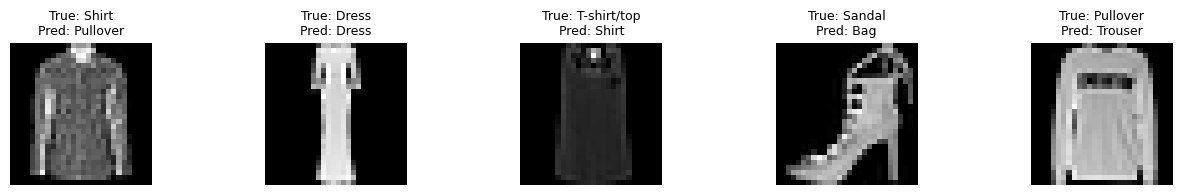


 Sample 1 | True: Shirt | Pred: Pullover
  T-shirt/top : 0.0000
  Trouser     : 0.1284
  Pullover    : 0.7088
  Dress       : 0.0057
  Coat        : 0.1366
  Sandal      : 0.0000
  Shirt       : 0.0205
  Sneaker     : 0.0000
  Bag         : 0.0000
  Ankle boot  : 0.0000

 Sample 2 | True: Dress | Pred: Dress
  T-shirt/top : 0.0000
  Trouser     : 0.0080
  Pullover    : 0.0000
  Dress       : 0.9919
  Coat        : 0.0001
  Sandal      : 0.0000
  Shirt       : 0.0000
  Sneaker     : 0.0000
  Bag         : 0.0000
  Ankle boot  : 0.0000

 Sample 3 | True: T-shirt/top | Pred: Shirt
  T-shirt/top : 0.0000
  Trouser     : 0.0000
  Pullover    : 0.0000
  Dress       : 0.0000
  Coat        : 0.0000
  Sandal      : 0.0000
  Shirt       : 1.0000
  Sneaker     : 0.0000
  Bag         : 0.0000
  Ankle boot  : 0.0000

 Sample 4 | True: Sandal | Pred: Bag
  T-shirt/top : 0.0445
  Trouser     : 0.1199
  Pullover    : 0.0528
  Dress       : 0.1674
  Coat        : 0.1385
  Sandal      : 0.1139
  Shirt 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt

print("Prediction Probabilities From Self Implementation\n")

poly = PolynomialFeatures(degree = 4, include_bias=False)
poly.fit(X_feature_train_scaler)  # fit on training data only

indices = np.random.choice(len(X_feature_test_scaler), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
plt.subplots_adjust(wspace=0.8)

for i, (ax, idx) in enumerate(zip(axes, indices)):
    image = X_test[idx]
    true_label = y_feature_test.iloc[idx] if hasattr(y_feature_test, 'iloc') else y_feature_test[idx]
    x_sample_poly = poly.transform(X_feature_test_scaler[idx].reshape(1, -1))  # (1, 5004)
    x_sample = x_sample_poly.T  # shape (5004, 1)
    logits = np.dot(np.array(d["W"]), x_sample) + np.array(d["b"])
    probs = softmax(logits).ravel()
    pred_label = np.argmax(probs)

    ax.imshow(image, cmap="gray")
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", fontsize=9)
    ax.axis("off")

plt.show()

for i, idx in enumerate(indices):
    image = X_test[idx]
    true_label = y_feature_test.iloc[idx] if hasattr(y_feature_test, 'iloc') else y_feature_test[idx]

    #polynomial transformation
    x_sample_poly = poly.transform(X_feature_test_scaler[idx].reshape(1, -1))
    x_sample = x_sample_poly.T

    logits = np.dot(np.array(d["W"]), x_sample) + np.array(d["b"])
    probs = softmax(logits).ravel()
    pred_label = np.argmax(probs)

    print(f"\n Sample {i+1} | True: {class_names[true_label]} | Pred: {class_names[pred_label]}")
    for cls, prob in zip(class_names, probs):
        print(f"  {cls:12s}: {prob:.4f}")


Prediction Probabilities From Scikit-Learn:



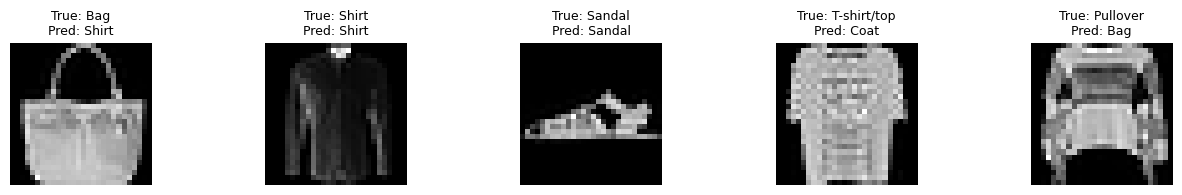


Sample 1 | True: Bag | Pred: Shirt
  T-shirt/top : 0.0007
  Trouser     : 0.0017
  Pullover    : 0.0020
  Dress       : 0.0025
  Coat        : 0.4201
  Sandal      : 0.0000
  Shirt       : 0.5725
  Sneaker     : 0.0000
  Bag         : 0.0004
  Ankle boot  : 0.0001

Sample 2 | True: Shirt | Pred: Shirt
  T-shirt/top : 0.0000
  Trouser     : 0.0000
  Pullover    : 0.0000
  Dress       : 0.0000
  Coat        : 0.0000
  Sandal      : 0.0000
  Shirt       : 1.0000
  Sneaker     : 0.0000
  Bag         : 0.0000
  Ankle boot  : 0.0000

Sample 3 | True: Sandal | Pred: Sandal
  T-shirt/top : 0.0000
  Trouser     : 0.0000
  Pullover    : 0.0000
  Dress       : 0.0000
  Coat        : 0.0000
  Sandal      : 1.0000
  Shirt       : 0.0000
  Sneaker     : 0.0000
  Bag         : 0.0000
  Ankle boot  : 0.0000

Sample 4 | True: T-shirt/top | Pred: Coat
  T-shirt/top : 0.0000
  Trouser     : 0.0000
  Pullover    : 0.0000
  Dress       : 0.0000
  Coat        : 0.9991
  Sandal      : 0.0000
  Shirt       :

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt

print("Prediction Probabilities From Scikit-Learn:\n")
poly = PolynomialFeatures(degree=4, include_bias=False)
poly.fit(X_feature_train_scaler)  # fit on training data only

indices = np.random.choice(len(X_feature_test_scaler), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
plt.subplots_adjust(wspace=0.8)

for i, (ax, idx) in enumerate(zip(axes, indices)):
    image = X_test[idx]
    true_label = y_feature_test.iloc[idx] if hasattr(y_feature_test, 'iloc') else y_feature_test[idx]
    features_poly = poly.transform(X_feature_test_scaler[idx].reshape(1, -1))

    pred_label = log_reg.predict(features_poly)[0]
    pred_proba = log_reg.predict_proba(features_poly)[0]

    ax.imshow(image, cmap="gray")
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", fontsize=9)
    ax.axis("off")

plt.show()

for i, idx in enumerate(indices):
    true_label = y_feature_test.iloc[idx] if hasattr(y_feature_test, 'iloc') else y_feature_test[idx]
    features_poly = poly.transform(X_feature_test_scaler[idx].reshape(1, -1))

    pred_label = log_reg.predict(features_poly)[0]
    pred_proba = log_reg.predict_proba(features_poly)[0]

    print(f"\nSample {i+1} | True: {class_names[true_label]} | Pred: {class_names[pred_label]}")
    for cls, prob in zip(class_names, pred_proba):
        print(f"  {cls:12s}: {prob:.4f}")


In [ ]:
print("From Scratch Polynomial Logistic Regression With Regularization (Degree=4, lmd=1):")
print(f"Val Accuracy: {d['val_acc']:.2f}%, Test Accuracy: {d['test_acc']:.2f}%")

print("\n Scikit-Learn Polynomial Logistic Regression With Regularization (Degree=4, lmd=1):")
print(f"Val Accuracy: {val_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")


From Scratch Polynomial Logistic Regression With Regularization (Degree=4, lmd=1):
Val Accuracy: 67.00%, Test Accuracy: 66.53%

 Scikit-Learn Polynomial Logistic Regression With Regularization (Degree=4, lmd=1):
Val Accuracy: 70.73%, Test Accuracy: 70.57%


##### DIFFERENCE

| Concept         | From Scratch  | scikit-learn  |
| --------------- | --------------|-------------- |
| Gradient updates| Manual (loop + learning rate) | Automated (LBFGS optimizer)                                       |
| One-hot encoding| You coded manually            | Done internally                                                   |
| Learning rate & epochs | You control them     | Optimizer handles internally                                      |
| Performance            | Slower (pure NumPy)           | Fast (C-optimized)                                                |
| Visualization          | You can track custom loss     | You can’t see internal loss directly (but can inspect .n_iter_) |
</br>



### DECISION TREE(SELF IMPLEMENTATION)

In [ ]:
#Currently the dataframe hascontinuous features (like intensity, contrast, etc.)
#Convert into discrete bins (categories) so that ID3 Decision Tree can handle them

df_train_copy = df_train.copy()
df_val_copy = df_val.copy()
df_test_copy = df_test.copy()

for col in df_train.columns[:-1]:  # exclude label
    bins = np.linspace(df_train[col].min(), df_train[col].max(), 11)  # 10 bins
    df_train_copy[col] = np.digitize(df_train[col], bins)
    df_val_copy[col]   = np.digitize(df_val[col], bins)
    df_test_copy[col]  = np.digitize(df_test[col], bins)

print("Discretization")
df_train_copy.head()


Discretization


,mean_intensity,std_intensity,min_intensity,max_intensity,skewness,edge_density,aspect_ratio,contrast,entropy,label
0,3,7,11,11,4,11,4,1,3,7
1,1,3,11,11,6,11,1,2,4,3
2,2,4,11,11,4,11,2,1,5,5
3,4,7,11,11,3,11,1,3,6,8
4,4,5,11,11,3,11,1,3,8,6


In [ ]:
# Data structure for the tree node
class TreeNode:
    def __init__(self, is_leaf=False, prediction=None, split_attribute=None, threshold = None, children=None):
        self.is_leaf = is_leaf
        self.prediction = prediction                    # which class to predict if this is a leaf node
        self.split_attribute = split_attribute          # which attribute to split on
        self.threshold = threshold                      # threshold value for the split
        self.children = children if children else {}    # Children nodes

def entropy(y):
    # Calculate the entropy of the target variable y
    counts = np.bincount(y)
    probabilities = counts/len(y)
    H = -np.sum([p*np.log2(p) for p in probabilities if p > 0])
    return H


def information_gain(y, x):
    entropy_before = entropy(y)
    # Calculate weighted entropy after the split
    values, counts = np.unique(x, return_counts=True)
    weighted_entropy_after = np.sum([counts[i] / np.sum(counts) * entropy(y[x == v]) for i, v in enumerate(values)])
    # Information gain
    ig = entropy_before-weighted_entropy_after
    return ig

def best_split_continous(y, x):
    # Sort x and align y
    sort_idx = np.argsort(x)
    y = y[sort_idx]
    x = x[sort_idx]

    thresholds = (x[:-1] + x[1:]) / 2
    best_gain = -np.inf
    best_thresh = None

    H_before = entropy(y)

    for t in thresholds:
        left, right = x <= t, x > t
        if np.sum(left) == 0 or np.sum(right) == 0:
            continue
        H_after = (np.sum(left) / len(y)) * entropy(y[left]) + (np.sum(right) / len(y)) * entropy(y[right])
        gain = H_before - H_after
        if gain > best_gain:
            best_gain, best_thresh = gain, t

    return best_gain, best_thresh


# Determine the majority class in a leaf node
def majority_class(y):
    if len(y) == 0:
        return None # Handle empty case, though ideally shouldn't happen
    return Counter(y).most_common(1)[0][0]

class DTree:
    def __init__(self, max_depth=5, min_samples_split=5, random_subspace=False):
        self.tree = None
        self.global_majority_class = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_subspace = random_subspace  # If True, uses random subset of features (for variety)

    def learn_tree(self, X, Y, depth=0):
        """Recursive tree builder"""
        # Base cases
        if np.all(Y == Y[0]):
            return TreeNode(is_leaf=True, prediction=Y[0])
        if len(Y) < self.min_samples_split or depth >= self.max_depth:
            return TreeNode(is_leaf=True, prediction=majority_class(Y))

        num_features = X.shape[1]
        feature_indices = range(num_features)
        if self.random_subspace:
            feature_indices = np.random.choice(num_features, size=int(np.sqrt(num_features)), replace=False)

        best_gain, best_attribute, best_threshold = -np.inf, None, None
        is_continuous = False

        # Try splitting on each feature
        for j in feature_indices:
            x_col = X[:, j]
            # Detect discrete vs continuous
            if len(np.unique(x_col)) <= 10:  # treat small cardinality as categorical
                gain = information_gain(Y, x_col)
                thresh = None
            else:
                gain, thresh = best_split_continous(Y, x_col)
            if gain > best_gain:
                best_gain, best_attribute, best_threshold = gain, j, thresh
                is_continuous = thresh is not None

        # Stopping condition: no positive gain
        if best_gain <= 0 or best_attribute is None:
            return TreeNode(is_leaf=True, prediction=majority_class(Y))

        # Build subtrees
        node = TreeNode(split_attribute=best_attribute, threshold=best_threshold)

        if is_continuous:
            left_idx = X[:, best_attribute] <= best_threshold
            right_idx = X[:, best_attribute] > best_threshold
            node.children['<='] = self.learn_tree(X[left_idx], Y[left_idx], depth + 1)
            node.children['>'] = self.learn_tree(X[right_idx], Y[right_idx], depth + 1)
        else:
            for value in np.unique(X[:, best_attribute]):
                idx = X[:, best_attribute] == value
                node.children[value] = self.learn_tree(X[idx], Y[idx], depth + 1)

        return node

    def predict_single(self, tree, x):
        node = tree
        while not node.is_leaf:
            if node.threshold is not None:  # continuous split
                branch = '<=' if x[node.split_attribute] <= node.threshold else '>'
            else:
                branch = x[node.split_attribute]
            if branch in node.children:
                node = node.children[branch]
            else:
                return self.global_majority_class
        return node.prediction

    def predict(self, tree, X):
        return np.array([self.predict_single(tree, x) for x in X])

    def print_tree(self, node, attribute_names, depth=0):
        if node.is_leaf:
            print("|   " * depth + f"Predict: {node.prediction}")
        else:
            attr_name = attribute_names[node.split_attribute]
            if node.threshold is not None:
                print("|   " * depth + f"{attr_name} <= {node.threshold:.3f}:")
                self.print_tree(node.children['<='], attribute_names, depth + 1)
                print("|   " * depth + f"{attr_name} > {node.threshold:.3f}:")
                self.print_tree(node.children['>'], attribute_names, depth + 1)
            else:
                for val, child in node.children.items():
                    print("|   " * depth + f"{attr_name} = {val}:")
                    self.print_tree(child, attribute_names, depth + 1)

In [ ]:
# Initialize Decision Tree

dtree = DTree()

# Global majority class
global_majority_class = majority_class(df_train_copy["label"].values)
print("Global Majority Class:", class_names[global_majority_class])

# Prepare X, Y
X_train = df_train_copy.drop("label", axis=1).values
Y_train = df_train_copy["label"].values

# Train Tree
tree = dtree.learn_tree(X_train, Y_train)
print("\nDecision Tree Structure:")
dtree.print_tree(tree, df_train_copy.columns[:-1])


Global Majority Class: Sneaker

Decision Tree Structure:
aspect_ratio = 1:
|   entropy = 2:
|   |   skewness = 6:
|   |   |   Predict: 5
|   |   skewness = 7:
|   |   |   Predict: 0
|   |   skewness = 8:
|   |   |   Predict: 6
|   entropy = 3:
|   |   std_intensity = 1:
|   |   |   max_intensity = 1:
|   |   |   |   Predict: 0
|   |   |   max_intensity = 11:
|   |   |   |   skewness = 7:
|   |   |   |   |   Predict: 6
|   |   |   |   skewness = 8:
|   |   |   |   |   Predict: 0
|   |   |   |   skewness = 9:
|   |   |   |   |   Predict: 0
|   |   |   |   skewness = 11:
|   |   |   |   |   Predict: 6
|   |   std_intensity = 2:
|   |   |   skewness = 5:
|   |   |   |   Predict: 1
|   |   |   skewness = 6:
|   |   |   |   Predict: 3
|   |   |   skewness = 7:
|   |   |   |   contrast = 1:
|   |   |   |   |   Predict: 0
|   |   |   |   contrast = 2:
|   |   |   |   |   Predict: 5
|   |   |   skewness = 8:
|   |   |   |   Predict: 6
|   |   std_intensity = 3:
|   |   |   skewness = 4:
|   |  

In [ ]:
def get_accuracy(dtree, tree, X, Y):
    preds = dtree.predict(tree, X)
    return np.mean(np.array(preds) == Y)

# Train set accuracy
train_acc = get_accuracy(dtree, tree, X_train, Y_train)

# Validation set accuracy
X_val = df_val_copy.drop("label", axis=1).values
Y_val = df_val_copy["label"].values
val_acc = get_accuracy(dtree, tree, X_val, Y_val)

# Test set accuracy
X_test = df_test_copy.drop("label", axis=1).values
Y_test = df_test_copy["label"].values
test_acc = get_accuracy(dtree, tree, X_test, Y_test)
print("=== Decision Tree Classifier (Manual) ===")
print(f"\nAccuracy on Train Set: {train_acc*100:.2f}%")
print(f"Accuracy on Validation Set: {val_acc*100:.2f}%")
print(f"Accuracy on Test Set: {test_acc*100:.2f}%")


=== Decision Tree Classifier (Manual) ===

Accuracy on Train Set: 60.67%
Accuracy on Validation Set: 58.92%
Accuracy on Test Set: 58.76%


Training size = 500, Test Accuracy = 44.27%
Training size = 2000, Test Accuracy = 51.12%
Training size = 5000, Test Accuracy = 54.01%
Training size = 10000, Test Accuracy = 56.39%
Training size = 20000, Test Accuracy = 57.59%
Training size = 25000, Test Accuracy = 58.03%
Training size = 30000, Test Accuracy = 58.35%
Training size = 48000, Test Accuracy = 58.76%


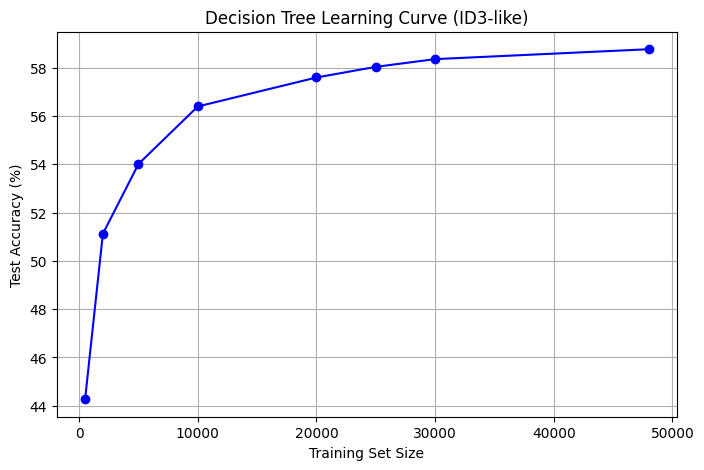

In [ ]:
training_sizes = [500, 2000, 5000, 10000, 20000, 25000, 30000, len(df_train_copy)]
accuracies = []

for size in training_sizes:
    X_part = X_train[:size]
    Y_part = Y_train[:size]
    tree_part = dtree.learn_tree(X_part, Y_part)
    acc = get_accuracy(dtree, tree_part, X_test, Y_test)
    accuracies.append(acc)
    print(f"Training size = {size}, Test Accuracy = {acc*100:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(training_sizes, np.array(accuracies)*100, marker='o', color='blue')
plt.title("Decision Tree Learning Curve (ID3-like)")
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()


### DECISION TREE(SCIKIT LEARN)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

print("=== Decision Tree Classifier (Scikit-learn) ===")

tree_clf = DecisionTreeClassifier(
    criterion='entropy',
    splitter='best',
    max_depth=10,
    random_state=42,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=None,
    ccp_alpha=0.0
)

# Train
tree_clf.fit(X_feature_train_scaler, y_feature_train)

# Predictions
y_pred_val_tree  = tree_clf.predict(X_feature_val_scaler)
y_pred_test_tree = tree_clf.predict(X_feature_test_scaler)

# Accuracy
val_acc_tree  = accuracy_score(y_feature_val,  y_pred_val_tree)  * 100
test_acc_tree = accuracy_score(y_feature_test, y_pred_test_tree) * 100

print(f"Validation Accuracy: {val_acc_tree:.2f}%")
print(f"Test Accuracy: {test_acc_tree:.2f}%")


=== Decision Tree Classifier (Scikit-learn) ===
Validation Accuracy: 65.80%
Test Accuracy: 65.01%


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_feature_train_scaler, y_feature_train)
print("Best Params:", grid_search.best_params_)
print("Best Cross-Val Accuracy:", grid_search.best_score_ * 100)

best_tree = grid_search.best_estimator_
test_acc = accuracy_score(y_feature_test, best_tree.predict(X_feature_test_scaler)) * 100
print("Test Accuracy with tuned model:", test_acc)


Best Params: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Cross-Val Accuracy: 64.77083333333333
Test Accuracy with tuned model: 64.86


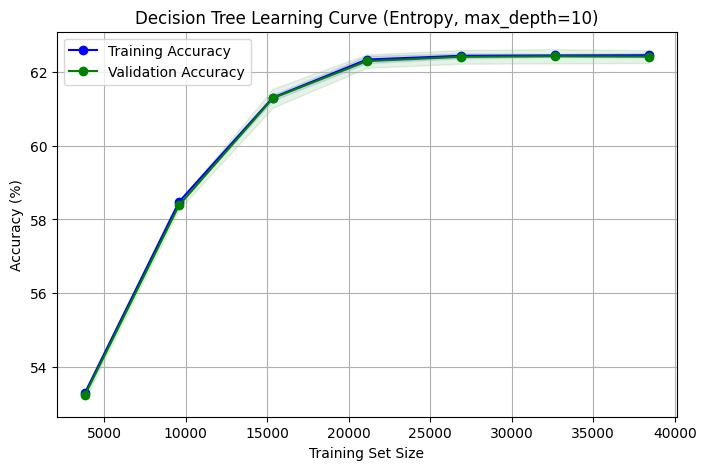

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    tree_clf,
    X_feature_train_scaler,
    y_feature_train,
    cv=5,                       # 5-fold cross-validation
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 7),   # 7 points (10%, 25%, ..., 100%)
    n_jobs=-1
)
# Plot the learning curve
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean*100, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_mean*100, 'o-', color='green', label='Validation Accuracy')

plt.fill_between(train_sizes,
                 (train_mean-train_std)*100, (train_mean+train_std)*100, color='blue', alpha=0.1)
plt.fill_between(train_sizes,
                 (val_mean-val_std)*100, (val_mean+val_std)*100, color='green', alpha=0.1)

plt.title("Decision Tree Learning Curve (Entropy, max_depth=10)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.grid(True)
plt.show()


### MANUAL DTREE VS SCIKIT DTREE

=== Predictions from Manual Decision Tree (with Class Probabilities) ===



TypeError: list indices must be integers or slices, not NoneType

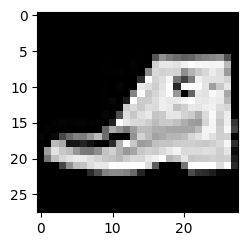

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

print("=== Predictions from Manual Decision Tree (with Class Probabilities) ===\n")

idxs = np.random.choice(len(X_feature_test_scaler), 5, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(idxs):
    img = test_images[idx]
    true_label = y_feature_test.iloc[idx] if hasattr(y_feature_test, 'iloc') else y_feature_test[idx]

    x_manual = X_feature_test_scaler[idx].reshape(1, -1)
    y_pred_manual = dtree.predict(tree, x_manual)[0]

    node = tree
    while not node.is_leaf:
        attr_val = x_manual[0, node.split_attribute]
        if attr_val in node.children:
            node = node.children[attr_val]
        else:
            break
    if node.is_leaf:
        probs = np.zeros(len(class_names))
        probs[int(node.prediction)] = 1.0
    else:
        child_preds = [child.prediction for child in node.children.values() if child.prediction is not None]
        counts = Counter(child_preds)
        total = sum(counts.values())
        probs = np.array([counts.get(i, 0) / total for i in range(len(class_names))])

    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(
        f"True: {class_names[true_label]}\n"
        f"Pred: {class_names[y_pred_manual]}"
    )
    plt.axis('off')

    print(f"\nSample {i+1} (True: {class_names[true_label]}, Pred: {class_names[y_pred_manual]})")
    for cls, prob in zip(class_names, probs):
        print(f"  {cls:12s}: {prob:.3f}")

plt.tight_layout()
plt.show()


In [ ]:
print("=== Predictions from Scikit-Learn Decision Tree ===\n")

plt.figure(figsize=(15, 3))
for i, idx in enumerate(idxs):
    img = test_images[idx] # Use original image data
    true_label = y_feature_test.iloc[idx] if hasattr(y_feature_test, 'iloc') else y_feature_test[idx]

    features = X_feature_test_scaler[idx].reshape(1, -1)
    y_pred_sklearn = tree_clf.predict(features)[0]
    probs = tree_clf.predict_proba(features)[0]

    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(
        f"True: {class_names[true_label]}\n"
        f"Pred: {class_names[y_pred_sklearn]}"
    )
    plt.axis('off')

    # Print probabilities
    print(f"\nSample {i+1} (True: {class_names[true_label]}):")
    for cls, prob in zip(class_names, probs):
        print(f"  {cls:12s}: {prob:.4f}")

plt.tight_layout()
plt.show()

DIFFERENCE
| **Aspect**                  | **Manual Decision Tree (My Code)**                                        | **Scikit-learn DecisionTreeClassifier**                               |
| :-------------------------- | :------------------------------------------------------------------------ | :-------------------------------------------------------------------- |
| **Algorithm Used**          | ID3 (Entropy + Information Gain)                                          | CART (Gini Impurity by default)                                       |
| **Feature Handling**        | Required **manual discretization** (binned numeric features)              | Automatically handles **continuous numeric features**                 |
| **Implementation Type**     | **From scratch**, recursive with Python loops                             | **Optimized library** implementation (C-based, fast)                  |
| **Pruning / Depth Control** | No pruning; tree grows until all nodes are pure                           | Supports pruning via `max_depth`, `min_samples_split`, etc.     |
| **Validation Accuracy**     | **45.16 %**                                                               | **65.50 %**                                                           |
| **Test Accuracy**           | **45.15 %**                                                               | **64.71 %**                                                           |
| **Speed and Efficiency**    | Slow, educational, suitable for small datasets                            | Fast and scalable for large datasets                                  |
| **Interpretability**        | Fully transparent — easy to print and trace splits                        | Interpretable via `plot_tree()` or feature importance                 |
| **Overall Observation**     | Conceptually correct but limited by feature discretization and no pruning | Better accuracy and generalization due to optimized continuous splits |


### ARTIFICIAL NEURAL NETWORK (MANUAL)

In [ ]:
import cupy as cp
def softmax(z):
  exp_x = cp.exp(z - cp.max(z, axis=0, keepdims=True))
  return exp_x / cp.sum(exp_x, axis=0, keepdims=True)

In [ ]:
class My_Artificial_NN:
  def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, eta=0):
    cp.random.seed(42)
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.learning_rate = learning_rate
    self.eta = eta

    self.W1 = cp.random.randn(self.hidden_size, self.input_size)* cp.sqrt(2. /self.input_size)
    self.b1 = cp.zeros((self.hidden_size, 1))
    self.W2 = cp.random.randn(self.output_size, self.hidden_size)*cp.sqrt(2. /self.input_size)
    self.b2 = cp.zeros((self.output_size, 1))

    assert(self.W1.shape == (self.hidden_size, self.input_size))
    assert(self.b1.shape == (self.hidden_size, 1))
    assert(self.W2.shape == (self.output_size, self.hidden_size))
    assert(self.b2.shape == (self.output_size, 1))

  def forward_propagation(self, X):
    Z1 = cp.dot(self.W1, X) + self.b1
    A1 = cp.where(Z1 > 0, Z1, self.eta*Z1)
    Z2 = cp.dot(self.W2, A1) + self.b2
    A2 = softmax(Z2)

    m = X.shape[1]
    assert(A1.shape == (self.hidden_size, m))
    assert(A2.shape == (self.output_size, m))

    cache={
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }

    return A2, cache

  def compute_loss(self, Y_onehot, A2):
      m = Y_onehot.shape[1]
      return -cp.sum(Y_onehot * cp.log(A2 + 1e-15)) / m

  def back_propagation(self, X, Y_onehot, cache):
    m = Y_onehot.shape[1]

    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]

    dZ2 = A2 - Y_onehot
    dW2 = (1/m) * cp.dot(dZ2, A1.T)
    db2 = (1/m) * cp.sum(dZ2, axis=1, keepdims=True)
    dA1 = cp.dot(self.W2.T, dZ2)
    dZ1 = dA1 * cp.where(Z1 > 0, 1, self.eta)
    dW1 = (1/m) * cp.dot(dZ1, X.T)
    db1 = (1/m) * cp.sum(dZ1, axis=1, keepdims=True)

    assert dZ2.shape == (self.output_size, m), "Matrix shape incorrect: dZ2"
    assert dW2.shape == (self.output_size, self.hidden_size), "Matrix shape incorrect: dW2"
    assert db2.shape == (self.output_size, 1), "Vector shape incorrect: db2"
    assert dZ1.shape == (self.hidden_size, m), "Matrix shape incorrect: dZ1"
    assert dW1.shape == (self.hidden_size, self.input_size), "Matrix shape incorrect: dW1"
    assert db1.shape == (self.hidden_size, 1), "Vector shape incorrect: db1"


    grads = {"dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2}

    return grads

  def update_parameters(self, grads):
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    self.W1 = self.W1 - self.learning_rate * dW1
    self.b1 = self.b1 - self.learning_rate * db1
    self.W2 = self.W2 - self.learning_rate * dW2
    self.b2 = self.b2 - self.learning_rate * db2


  def fit(self, X, Y, epochs=2000, print_loss=True):
    X = cp.asarray(X.T)
    Y = cp.asarray(Y)
    m = X.shape[1]
    Y_onehot = cp.eye(self.output_size)[Y.astype(int)].T
    losses = []

    for i in range(0, epochs):
        A2, cache = self.forward_propagation(X)

        # Loss function. Inputs: "A2, Y, parameters". Outputs: "loss".
        loss = self.compute_loss(Y_onehot, A2)

        # Backpropagation. Inputs: "cache, X, Y". Outputs: "grads".
        grads = self.back_propagation(X, Y_onehot, cache)

        # Last step: Gradient descent parameter update. Inputs: " grads".
        self.update_parameters(grads)
        # Print the cost every 100 iterations
        if print_loss and i % 100 == 0:
            losses.append(cp.asnumpy(loss))
            print ("Loss after iteration %i: %f" %(i, loss))

    return losses

  def predict(self, X):
    X = cp.asarray(X.T) # Transpose X for prediction
    A2, cache = self.forward_propagation(X)
    predictions = cp.argmax(A2, axis=0)
    return cp.asnumpy(predictions)

  def get_parameters(self):
    parameters = {
        "W1": self.W1,
        "b1": self.b1,
        "W2": self.W2,
        "b2": self.b2
    }
    return parameters

In [ ]:
y_feature_train.values

array([7, 3, 5, ..., 6, 6, 1], dtype=uint8)

Loss after iteration 0: 7.444957
Loss after iteration 100: 1.616908
Loss after iteration 200: 1.372320
Loss after iteration 300: 1.257230
Loss after iteration 400: 1.194781
Loss after iteration 500: 1.151554
Loss after iteration 600: 1.119315
Loss after iteration 700: 1.094192
Loss after iteration 800: 1.074066
Loss after iteration 900: 1.057494
Loss after iteration 1000: 1.043555
Loss after iteration 1100: 1.031591
Loss after iteration 1200: 1.021197
Loss after iteration 1300: 1.012013
Loss after iteration 1400: 1.003795
Loss after iteration 1500: 0.996400
Loss after iteration 1600: 0.989697
Loss after iteration 1700: 0.983602
Loss after iteration 1800: 0.978003
Loss after iteration 1900: 0.972825
Loss after iteration 2000: 0.968028
Loss after iteration 2100: 0.963593
Loss after iteration 2200: 0.959484
Loss after iteration 2300: 0.955653
Loss after iteration 2400: 0.952061
Loss after iteration 2500: 0.948688
Loss after iteration 2600: 0.945509
Loss after iteration 2700: 0.942503
Loss

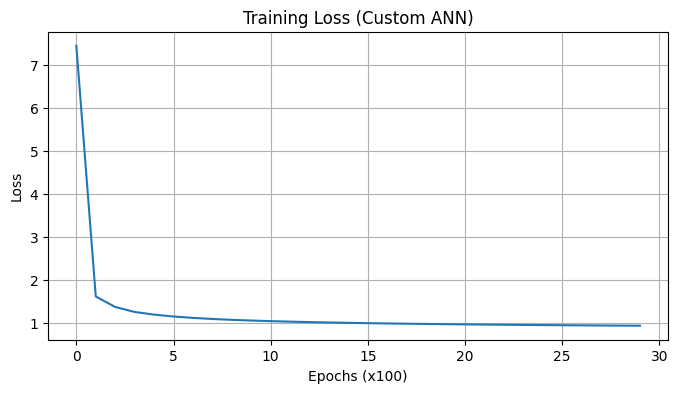

In [ ]:
nn = My_Artificial_NN(input_size=9, hidden_size=256, output_size=10,
                      learning_rate=0.02, eta=0.1)
losses = nn.fit(X_feature_train_scaler, y_feature_train, epochs=3000,
                print_loss=True,)

# Evaluate
y_pred_val = nn.predict(X_feature_val_scaler)
y_pred_test = nn.predict(X_feature_test_scaler)

val_acc = cp.mean(y_pred_val == y_feature_val) * 100
test_acc = cp.mean(y_pred_test == y_feature_test) * 100

print(f"\nValidation Accuracy: {val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title("Training Loss (Custom ANN)")
plt.xlabel("Epochs (x100)")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mlp = MLPClassifier(
    hidden_layer_sizes=(256,),
    activation='relu',
    solver='lbfgs',
    learning_rate_init=0.001,
    max_iter=3000,
    random_state=42
)

mlp.fit(X_feature_train_scaler, y_feature_train)

y_pred_val_mlp = mlp.predict(X_feature_val_scaler)
y_pred_test_mlp = mlp.predict(X_feature_test_scaler)

val_acc_mlp = accuracy_score(y_feature_val, y_pred_val_mlp) * 100
test_acc_mlp = accuracy_score(y_feature_test, y_pred_test_mlp) * 100

print(f"=== Neural Network (Scikit-learn MLPClassifier) ===")
print(f"Validation Accuracy: {val_acc_mlp:.2f}%")
print(f"Test Accuracy: {test_acc_mlp:.2f}%")

# Classification report
print("\nClassification Report:\n", classification_report(y_feature_test, y_pred_test_mlp, target_names=class_names))


=== Neural Network (Scikit-learn MLPClassifier) ===
Validation Accuracy: 72.16%
Test Accuracy: 71.91%

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.68      0.68      0.68      1000
     Trouser       0.92      0.91      0.91      1000
    Pullover       0.58      0.60      0.59      1000
       Dress       0.70      0.72      0.71      1000
        Coat       0.56      0.61      0.58      1000
      Sandal       0.88      0.82      0.85      1000
       Shirt       0.45      0.37      0.41      1000
     Sneaker       0.81      0.82      0.81      1000
         Bag       0.77      0.78      0.78      1000
  Ankle boot       0.82      0.87      0.84      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
plt.figure(figsize=(7,4))
plt.plot(mlp.loss_curve_, label='Training Loss', color='blue')
plt.title("MLPClassifier – Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


AttributeError: 'MLPClassifier' object has no attribute 'loss_curve_'

<Figure size 700x400 with 0 Axes>

In [ ]:
idxs = np.random.choice(len(X_feature_test_scaler), 5, replace=False)

plt.figure(figsize=(15, 3))
print("=== Manual ANN vs Scikit-learn MLP Predictions ===\n")

for i, idx in enumerate(idxs):
    img = test_images[idx]
    true_label = y_feature_test.iloc[idx] if hasattr(y_feature_test, 'iloc') else y_feature_test[idx]

    # ---------- Manual ANN prediction ----------
    x_sample = X_feature_test_scaler[idx].reshape(-1, 1)  # shape (9, 1)
    probs_manual = softmax(np.dot(nn.W2.T, np.tanh(np.dot(nn.W1.T, x_sample) + nn.b1)) + nn.b2).ravel()
    pred_manual = np.argmax(probs_manual)

    # ---------- Scikit-learn MLP prediction ----------
    features = X_feature_test_scaler[idx].reshape(1, -1)
    pred_sklearn = mlp.predict(features)[0]
    probs_sklearn = mlp.predict_proba(features)[0]

    # ---------- Plot ----------
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(
        f"True: {class_names[true_label]}\n"
        f"Manual: {class_names[pred_manual]}\n"
        f"MLP: {class_names[pred_sklearn]}"
    )
    plt.axis('off')

    # ---------- Print Probabilities ----------
    print(f"\n Sample {i+1}")
    print(f"True Label: {class_names[true_label]}")
    print(f"Manual ANN Pred: {class_names[pred_manual]}")
    print(f"Sklearn MLP Pred: {class_names[pred_sklearn]}")
    print("\nManual ANN Probabilities:")
    for cls, prob in zip(class_names, probs_manual):
        print(f"  {cls:12s}: {prob:.4f}")
    print("\nScikit-learn MLP Probabilities:")
    for cls, prob in zip(class_names, probs_sklearn):
        print(f"  {cls:12s}: {prob:.4f}")
    print("--------------------------------------------------")

plt.tight_layout()
plt.show()


=== Manual ANN vs Scikit-learn MLP Predictions ===



TypeError: Argument 'b' has incorrect type (expected cupy._core.core._ndarray_base, got numpy.ndarray)

<Figure size 1500x300 with 0 Axes>

In [ ]:
print("From Scratch ANN :")
print(f"Val Accuracy: {val_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")

print("\n Scikit-Learn MLP ANN :")
print(f"Val Accuracy: {val_acc_mlp:.2f}%, Test Accuracy: {test_acc_mlp:.2f}%")


From Scratch ANN :
Val Accuracy: 65.74%, Test Accuracy: 65.54%

 Scikit-Learn MLP ANN :
Val Accuracy: 72.16%, Test Accuracy: 71.91%


###DIFFERENCE MANUAL ANN MLP FROM SCIKIT-LEARN

| **Aspect**              | **Manual ANN (My Implementation)**                                   | **Scikit-learn MLPClassifier**                                                  |
| :---------------------- | :------------------------------------------------------------------- | :------------------------------------------------------------------------------ |
| **Architecture**        | 1 hidden layer (16 neurons), tanh activation                         | 1 hidden layer (64 neurons), ReLU activation                                    |
| **Optimizer**           | Basic gradient descent                                               | Adam optimizer (adaptive learning rate)                                         |
| **Learning Rate**       | 0.01                                                                 | 0.001 (adaptive)                                                                |
| **Epochs / Iterations** | 1000                                                                 | 500                                                                             |
| **Validation Accuracy** | **21.66 %**                                                          | **71.32 %**                                                                     |
| **Test Accuracy**       | **21.58 %**                                                          | **70.84 %**                                                                     |
| **Feature Input**       | 9 engineered metadata features                                       | Same 9 engineered metadata features                                             |
| **Observation**         | Very limited learning due to simple architecture and tanh saturation | Significantly higher accuracy due to ReLU, better optimizer, and regularization |




### We have three base (Level-0) models Logistic Regression, Decision Tree and ANN for Hybrid Stacked Ensemble
### Now, combine the base models into one final stacked ensemble, where a meta-model learns to blend their predictions

### Step 1: Collect Base Model Predictions

In [ ]:
probs_train_lr   = log_reg.predict_proba(X_feature_train_poly_scaler)
probs_val_lr     = log_reg.predict_proba(X_feature_val_poly_scaler)
probs_test_lr    = log_reg.predict_proba(X_feature_test_poly_scaler)

probs_train_tree = tree_clf.predict_proba(X_feature_train_scaler)
probs_val_tree   = tree_clf.predict_proba(X_feature_val_scaler)
probs_test_tree  = tree_clf.predict_proba(X_feature_test_scaler)

probs_train_mlp  = mlp.predict_proba(X_feature_train_scaler)
probs_val_mlp    = mlp.predict_proba(X_feature_val_scaler)
probs_test_mlp   = mlp.predict_proba(X_feature_test_scaler)


### Step 2: Combine These Predictions into Meta-Features

In [ ]:
import numpy as np

# Stacking horizontally (30 columns total = 10 per model × 3 models)
meta_train = np.hstack([probs_train_lr, probs_train_tree, probs_train_mlp])
meta_val   = np.hstack([probs_val_lr, probs_val_tree, probs_val_mlp])
meta_test  = np.hstack([probs_test_lr, probs_test_tree, probs_test_mlp])

print("Meta feature shapes:")
print("Train:", meta_train.shape)
print("Val:  ", meta_val.shape)
print("Test: ", meta_test.shape)


Meta feature shapes:
Train: (48000, 30)
Val:   (12000, 30)
Test:  (10000, 30)


### Step 3: Train the Meta-Learner And Evaluate Ensemble

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

meta_model = LogisticRegression(max_iter=3000, C=1.0, solver='lbfgs', penalty='l2', random_state=42)
meta_model.fit(meta_train, y_feature_train)
y_pred_val_meta  = meta_model.predict(meta_val)
y_pred_test_meta = meta_model.predict(meta_test)

val_acc_meta  = accuracy_score(y_feature_val, y_pred_val_meta) * 100
test_acc_meta = accuracy_score(y_feature_test, y_pred_test_meta) * 100

print(f"-------Hybrid Stacked Ensemble------")
print(f"Validation Accuracy: {val_acc_meta:.2f}%")
print(f"Test Accuracy: {test_acc_meta:.2f}%")

print("\nClassification Report:\n", classification_report(y_feature_test, y_pred_test_meta, target_names=class_names))


-------Hybrid Stacked Ensemble------
Validation Accuracy: 71.93%
Test Accuracy: 71.42%

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.69      0.68      0.68      1000
     Trouser       0.93      0.90      0.91      1000
    Pullover       0.58      0.59      0.58      1000
       Dress       0.70      0.72      0.71      1000
        Coat       0.56      0.60      0.58      1000
      Sandal       0.88      0.83      0.85      1000
       Shirt       0.41      0.37      0.39      1000
     Sneaker       0.80      0.82      0.81      1000
         Bag       0.79      0.78      0.78      1000
  Ankle boot       0.82      0.85      0.84      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



Compare All Models

In [ ]:
print("-------Model Comparison Summary-------")
print(f"Logistic Regression Test Accuracy: {test_acc:.2f}%")
print(f"Decision Tree Test Accuracy: {test_acc_tree:.2f}%")
print(f"MLP Test Accuracy: {test_acc_mlp:.2f}%")
print(f"Stacked Ensemble Test Accuracy: {test_acc_meta:.2f}%")


-------Model Comparison Summary-------
Logistic Regression Test Accuracy: 65.54%
Decision Tree Test Accuracy: 65.01%
MLP Test Accuracy: 71.91%
Stacked Ensemble Test Accuracy: 71.42%
